In [3]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import  provideData
from Utils.transform import cutOut

Num GPUs: 1


In [4]:
#slices = [272,304,272,304]
slices = [256,320,256,320]
cutOutFrame = cutOut(slices)

PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")
dimension = (64,64)
channels = 5
optimizer = Adam( lr = 1e-3 )
batch_size=50
year = [2015,2016,2017]
train, test = provideData(dimension=dimension,
                          batch_size=batch_size,
                          channels = channels,
                          timeToPred = 30,
                          year = year,
                          transform=None,
                          preTransformation=PRETRAINING_TRANSFORMATIONS)



tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)


Found Year :  2015 => won't download this year again... please check for consistency
Found Year :  2016 => won't download this year again... please check for consistency
Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 
[DEBUG] Data
[DEBUG] time to predict:  30
SORTTING OUUUT 64784
[DEBUG] Data
[DEBUG] time to predict:  30
SORTTING OUUUT 25135


In [8]:


tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)
                           

    
from tensorflow_probability.python.internal import distribution_util as dist_util
def zeroInflatedPoisson(output,event_shape=()):
    
   
    s = Flatten()(output[:,:,:,:1])
    rate= Flatten()(output[:,:,:,1:2])
    rate = tf.math.exp(rate) #A 
    s = tf.math.sigmoid(s)
    
    logits = tf.stack([1-s, s],axis=2)
    cat = tfd.Categorical(logits=logits)

    
    components = [tfd.Deterministic(loc=tf.zeros_like(rate)),
                  tfd.Poisson(rate=rate)]

    mixture = tfd.Mixture(
          cat=cat,
          components=components)
    mixture = tfp.distributions.Independent(mixture,name="ZeroInflated")
    return mixture

def testnetZeroInflatedPoisson(input_shape,
           n_predictions=1,
           simpleclassification=None,
           flatten_output=False,
           activation_hidden="relu",
           activation_output="relu"):


    

    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up02 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64

    
    layer = Conv2D(2, (1, 1), activation="linear")(up01)  # 1 x 64x64

    layer_1 = Flatten()(layer[:,:,:,:1])
    layer_2 = Flatten()(layer[:,:,:,1:2])
    layer_1 = Dropout(0.25)(layer_1)
    layer_2 = Dropout(0.25)(layer_2)
    layer_1 = Dense(64*64,activation="sigmoid")(layer_1)
    layer_2 = Dense(64*64,activation="selu")(layer_2)
    layer_1 = tf.keras.layers.Reshape((64,64,1))(layer_1)
    layer_2 = tf.keras.layers.Reshape((64,64,1))(layer_2)
    input_dist= tf.concat([layer_1,layer_2],axis=-1)

    output_dist = tfp.layers.DistributionLambda(name="DistributionLayer",
                                                make_distribution_fn=lambda t: tfp.distributions.Independent(
                                                tfd.Mixture(
                                                    cat=tfd.Categorical(tf.stack([1-t[...,:1], t[...,:1]],axis=-1)),
                                                    components=[tfd.Deterministic(loc=tf.zeros_like(t[...,:1])),
                                                      tfd.Poisson(rate=tf.math.softplus(t[...,1:2]))])
                                                    ,name="ZeroInflated",reinterpreted_batch_ndims=0 ))
    

    output = output_dist(input_dist)
    model = Model(inputs=inputs, outputs=output)
    return model




In [9]:
modelPath = "./model_data/testnetZeroInflatedPoisson_30Min"
if not os.path.exists(modelPath):
    os.mkdir(modelPath)

model = testnetZeroInflatedPoisson((*dimension,5))
model.compile(loss=NLL, optimizer=Adam( lr= 1e-2 ))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 10)   460         input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 64, 64, 10)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 32, 32, 10)   0           activation_4[0][0]               
____________________________________________________________________________________________

In [10]:
from tensorflow.keras.callbacks import *

modelname = os.path.join(modelPath,'model-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5')
checkpoint = ModelCheckpoint(modelname, verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 
history = model.fit(train,validation_data=test,epochs=100,callbacks=checkpoint)

Epoch 1/100
1295/1295 [==============================] - 67s 52ms/step - loss: 2.8739 - val_loss: 2.9871
Epoch 2/100
1295/1295 [==============================] - 67s 52ms/step - loss: 2.7991 - val_loss: 2.9648
Epoch 3/100
1295/1295 [==============================] - 67s 52ms/step - loss: 2.4515 - val_loss: 2.4247
Epoch 4/100
1295/1295 [==============================] - 59s 46ms/step - loss: 2.2029 - val_loss: 2.3737
Epoch 5/100
1295/1295 [==============================] - 48s 37ms/step - loss: 2.1372 - val_loss: 2.3484
Epoch 6/100
1295/1295 [==============================] - 48s 37ms/step - loss: 2.0710 - val_loss: 2.1974
Epoch 7/100
1295/1295 [==============================] - 48s 37ms/step - loss: 1.8470 - val_loss: 2.1408
Epoch 8/100
1295/1295 [==============================] - 48s 37ms/step - loss: 1.8040 - val_loss: 2.1702
Epoch 9/100
1295/1295 [==============================] - 47s 37ms/step - loss: 1.7934 - val_loss: 2.2674
Epoch 10/100
1295/1295 [==============================]

1295/1295 [==============================] - 47s 36ms/step - loss: 1.4545 - val_loss: 2.3643
Epoch 79/100
1295/1295 [==============================] - 47s 36ms/step - loss: 1.4716 - val_loss: 2.3973
Epoch 80/100
1295/1295 [==============================] - 47s 36ms/step - loss: 1.4504 - val_loss: 2.4198
Epoch 81/100
1295/1295 [==============================] - 47s 36ms/step - loss: 1.4464 - val_loss: 2.3963
Epoch 82/100
1295/1295 [==============================] - 47s 36ms/step - loss: 1.4532 - val_loss: 2.4180
Epoch 83/100
1295/1295 [==============================] - 47s 36ms/step - loss: 1.4535 - val_loss: 2.3553
Epoch 84/100
1295/1295 [==============================] - 47s 36ms/step - loss: 1.4435 - val_loss: 2.4162
Epoch 85/100
1295/1295 [==============================] - 47s 37ms/step - loss: 1.4579 - val_loss: 2.3878
Epoch 86/100
1295/1295 [==============================] - 47s 36ms/step - loss: 1.4463 - val_loss: 2.4042
Epoch 87/100
1295/1295 [==============================] - 4

In [11]:

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
#model = t.model
pred = None
label = None
pred = 10
test.on_epoch_end()
mean = []
stdev = []
label = []
predictions = []
for x,y in test:
    for i in range(batch_size):
        if y[i,:,:,:].max() > 0:
            pred = model(np.array([x[i,:,:,:]]))
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
            predictions.append((pred,y[i:,:,:]))
            if len(label) == 10:
                break
        #mean = model(x).mean()
        #std = model(x).stddev()
        #label = y
        break
    if len(label) == 10:
                break

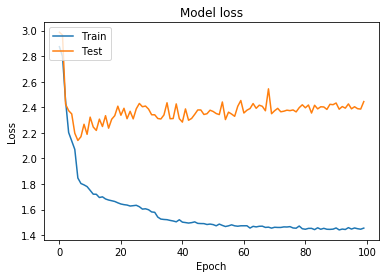

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
def plotHistory():

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()

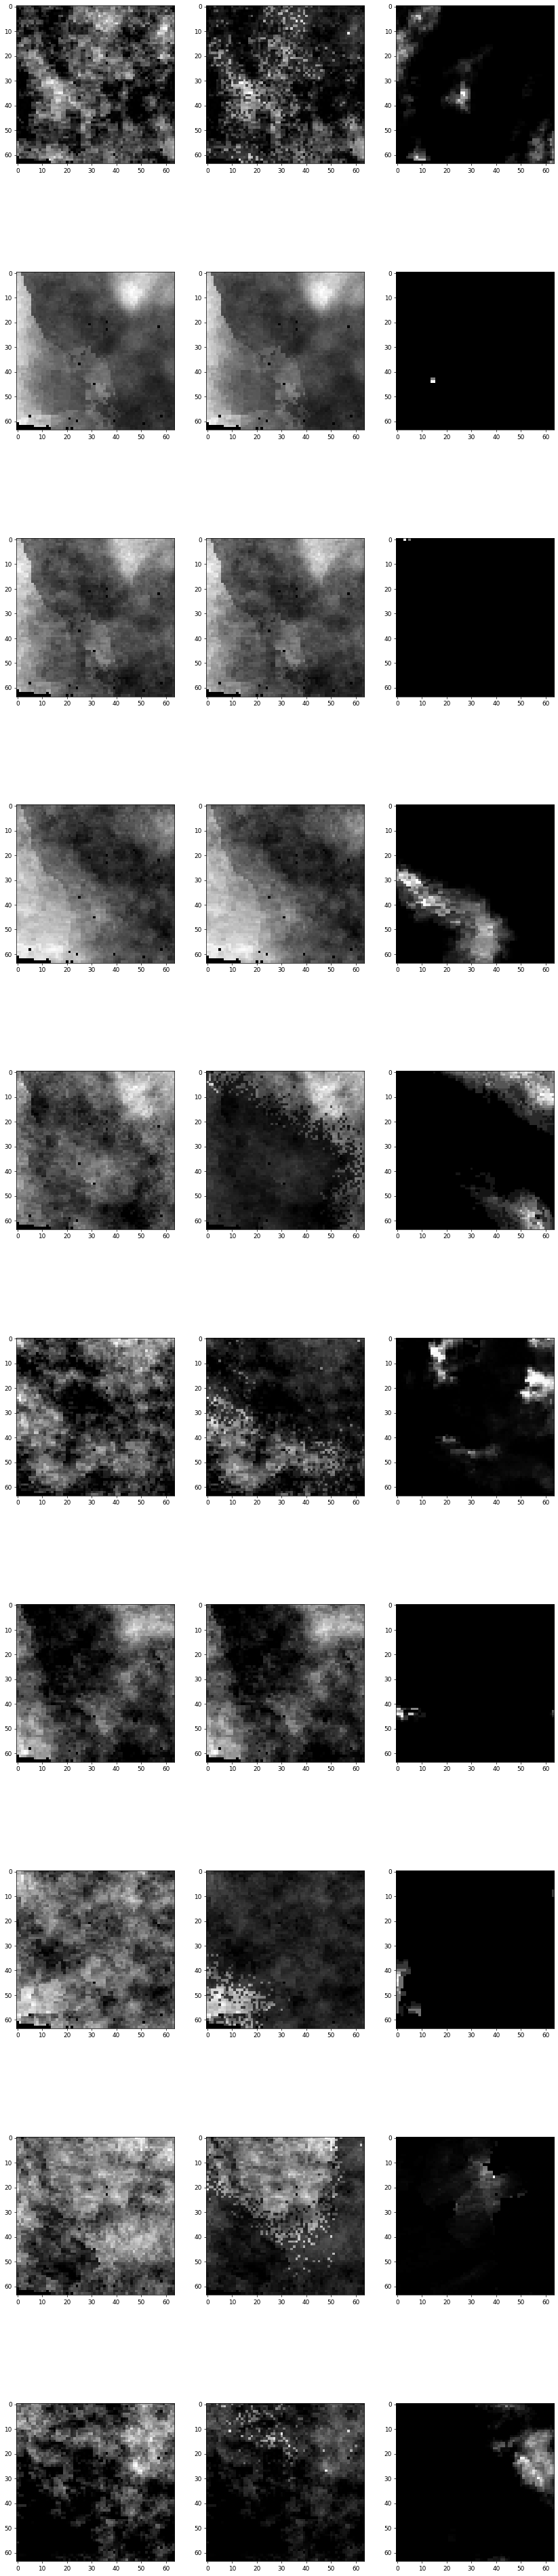

In [13]:
fig, axes = plt.subplots(10, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 10:
        break
    axes[batch,1].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")

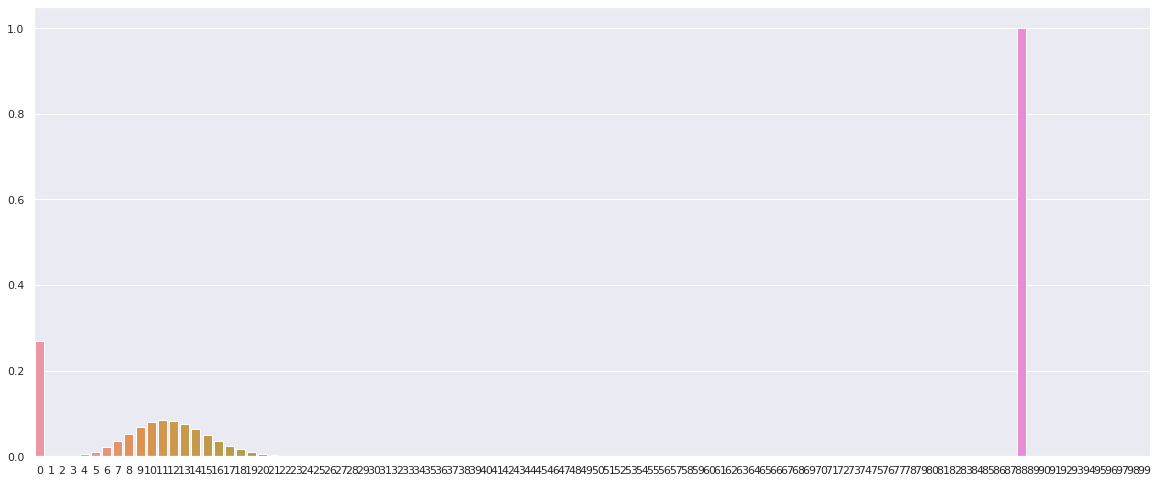

In [14]:
index = 0

p,l = predictions[index]
l = l[0]
ones = np.ones_like(l)
values = 100
value_array = np.repeat(ones,values,axis=-1)
z = value_array.shape[-1]
a = np.arange(values)
for i in range(values):
    value_array[:,:,i] *= i
    
probs_values = np.array(p.prob(value_array)[0])

max_value = l.max()
idcs = np.where(l == max_value)

x_i,y_i = idcs[0],idcs[1]
y_ = probs_values[x_i,y_i,:][0]
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

true_v = np.zeros_like(y_)
true_v[max_value] = 1
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.barplot(a,y_)
sns.barplot(a,true_v)
plt.show()


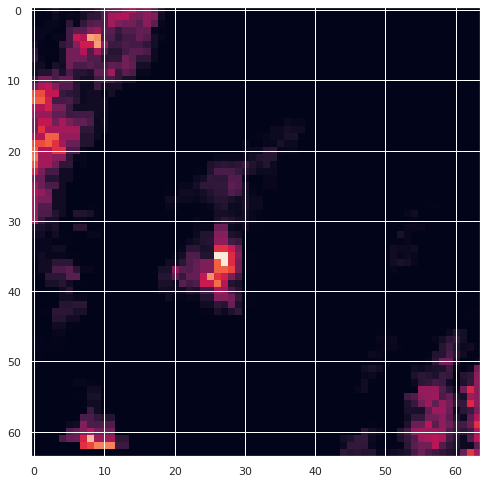

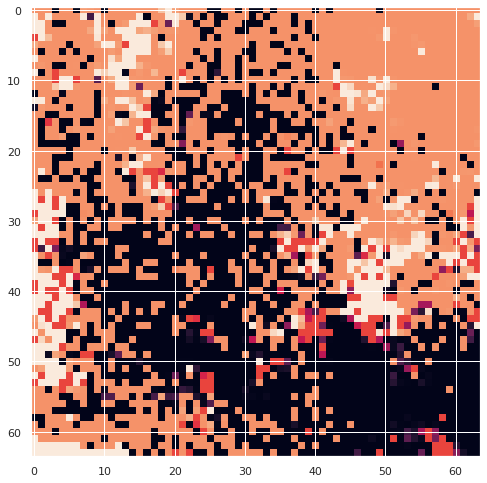

In [15]:

plt.imshow(l[:,:,0])
plt.show()

plt.imshow(probs_values[:,:,0])
plt.show()


In [16]:
#def simpleBaseline(label,prediction):
    
#simpleBaseline
def dist2Classes(dist):
    zeros = np.zeros(dist.shape)
    # Wahrscheinlichkeit für kein Regen
    rain = np.array(dist.cdf(zeros))
    
    # Wahrscheinlichkeit kein Regen größer 50%, 
    mask = (rain > 0.5)
    
    return mask

def labelToMask(label):
    # Gibt Maske mit kein Regen zurück
    return (label == 0)

true_pos = np.zeros((1,64,64,1))
true_neg = true_pos.copy()
false_pos = true_pos.copy()
false_neg = true_pos.copy()
rain_total = 0
total = 0

simple_true_pos = np.zeros((1,64,64,1))
simple_true_neg = true_pos.copy()
simple_false_pos = true_pos.copy()
simple_false_neg = true_pos.copy()
for i,(x,y) in enumerate(test):
    batchsize = y.shape[0]
    
    for batch in range(batchsize):
        print("{}/{}".format((i*batchsize)+batch,len(test)*batchsize),end="\r")
        pred = model(np.array([x[batch,:,:,:]]))
        
        pred_mask = dist2Classes(pred)
        labl_mask = labelToMask(y[batch,:,:,:])
        #              Kein Regen Predicted & Label = Kein Regen
        false_neg  += (pred_mask == True)    & (labl_mask == True)
        #              Regen Predicted       & Label = Kein Regen
        true_neg   += (pred_mask == False)   & (labl_mask == True)
        #              Regen Predicted       & Label = Regen
        true_pos   += (pred_mask == False)   & (labl_mask == False)
        #              Kein Regen Predicted  & Label = Regen
        false_pos  += (pred_mask == True)    & (labl_mask == False)
        rain_total += (~labl_mask).sum()
        total += labl_mask.sum() + (~labl_mask).sum()
        
        rain_atm = np.array(x[batch,:,:,-1])
        label_simple = labelToMask(rain_atm)
        
        # Simple Baseline
        
        rain_atm = x[batch,:,:,-1:]
        pred_simple = labelToMask(rain_atm)
        #              Kein Regen Predicted & Label = Kein Regen
        simple_false_neg  += (pred_simple == True)    & (labl_mask == True)
        #              Regen Predicted       & Label = Kein Regen
        simple_true_neg   += (pred_simple == False)   & (labl_mask == True)
        #              Regen Predicted       & Label = Regen
        simple_true_pos   += (pred_simple == False)   & (labl_mask == False)
        #              Kein Regen Predicted  & Label = Regen
        simple_false_pos  += (pred_simple == True)    & (labl_mask == False)
        

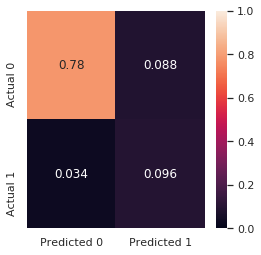

In [17]:
import seaborn as sn
import pandas as pd
plt.figure(figsize = (4,4))

mat = np.array([[false_neg.sum(),false_pos.sum()],[true_neg.sum(),true_pos.sum()]])
total = mat.sum()
df_cm = pd.DataFrame(mat/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
sn.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
plt.show()

Simple Baseline


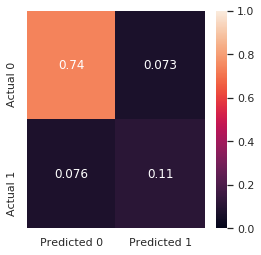

In [18]:
plt.figure(figsize = (4,4))
print("Simple Baseline")
mat_simple = np.array([[simple_false_neg.sum(),simple_false_pos.sum()],[simple_true_neg.sum(),simple_true_pos.sum()]])
total = mat.sum()
df_cm = pd.DataFrame(mat_simple/total,index = ["Actual 0","Actual 1"],columns=["Predicted 0","Predicted 1"])
sn.heatmap(df_cm, annot=True,vmin=0.0, vmax=1.0)
plt.show()

In [19]:

print("Regen total: {}\nKein Regen total: {}\nVerhältnis: {:.4f}\n".format(rain_total,total-rain_total,rain_total/(total)))

Regen total: 18865777
Kein Regen total: 83943823.0
Verhältnis: 0.1835

